In [27]:
import tensorflow as tf
import tensorflow.keras.layers as layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
from itertools import islice
from collections import OrderedDict

from preprocessing.numeric import *
from preprocessing.tokens import *

tf.__version__, tf.keras.__version__

('2.2.0', '2.3.0-tf')

In [28]:
train = tf.data.experimental.make_csv_dataset("data/train.tsv",
                                           field_delim="\t",
                                           batch_size=5,
#                                            compression_type="GZIP",
                                           label_name="Click",
                                           num_epochs=1)

test = tf.data.experimental.make_csv_dataset("data/test.tsv",
                                           field_delim="\t",
                                           batch_size=10_000,
                                           label_name="Click",
                                           num_epochs=1)

NUMERIC_FEATURES = ["Depth", "Position", "Gender", "Age", "UserID", "AdvertiserId"]
TOKENS_FEATURES = ["AdKeyword_tokens", "AdTitle_tokens", "AdDescription_tokens", "Query_tokens"]

---
#### Numeric features

In [29]:
y_train = train\
    .map(ExtractLabels(), deterministic=True)

y_test = test\
    .map(ExtractLabels(), deterministic=True)

x_num_train = train\
    .map(PackNumericFeatures(NUMERIC_FEATURES), deterministic=True)\
    .map(Normalize(NUMERIC_FEATURES), deterministic=True)

x_num_test = test\
    .map(PackNumericFeatures(NUMERIC_FEATURES), deterministic=True)\
    .map(Normalize(NUMERIC_FEATURES), deterministic=True)

---
#### Sequence of tokens features
AdKeyword_tokens, AdTitle_tokens, AdDescription_tokens, Query_tokens

Jak stworzyć słownik do modelu?

In [30]:
n_words = 2_000
max_length = 5

x_tokens_train = train\
    .map(Tokenize("AdKeyword_tokens", n_words, max_length), deterministic=True)

x_tokens_test = test\
    .map(Tokenize("AdKeyword_tokens", n_words, max_length), deterministic=True)

---
#### Merging datasets

In [31]:
train_dataset = tf.data.Dataset.zip(({"numeric": x_num_train, "tokens": x_tokens_train}, y_train))
test_dataset = tf.data.Dataset.zip(({"numeric": x_num_test, "tokens": x_tokens_test}, y_test))

In [32]:
next(iter(train))

(OrderedDict([('DisplayURL',
               <tf.Tensor: shape=(5,), dtype=float32, numpy=
               array([7.9039147e+18, 1.3557133e+19, 8.9945571e+18, 1.4340390e+19,
                      1.0726002e+19], dtype=float32)>),
              ('AdId',
               <tf.Tensor: shape=(5,), dtype=int32, numpy=array([21162526, 20706014, 20030150, 21163921, 20036558], dtype=int32)>),
              ('AdvertiserId',
               <tf.Tensor: shape=(5,), dtype=int32, numpy=array([ 1325, 34246, 23799, 23808, 23800], dtype=int32)>),
              ('Depth',
               <tf.Tensor: shape=(5,), dtype=int32, numpy=array([1, 2, 2, 2, 1], dtype=int32)>),
              ('Position',
               <tf.Tensor: shape=(5,), dtype=int32, numpy=array([1, 1, 2, 2, 1], dtype=int32)>),
              ('UserID',
               <tf.Tensor: shape=(5,), dtype=int32, numpy=array([ 7973585,  3524282, 11239490,  3030166,   151864], dtype=int32)>),
              ('Gender',
               <tf.Tensor: shape=(5,), dty

In [33]:
next(iter(train_dataset))

({'numeric': <tf.Tensor: shape=(5, 6), dtype=float32, numpy=
  array([[-1.2974142 , -0.7385462 ,  1.0546501 , -1.5065126 ,  2.5104692 ,
           0.07732566],
         [-1.2974142 , -0.7385462 , -2.7247539 , -0.14810055, -0.79318994,
           0.07591647],
         [ 0.14680085, -0.7385462 , -0.8350519 , -0.82730657, -0.8886711 ,
          -1.8871858 ],
         [ 0.14680085,  0.8854252 , -0.8350519 ,  1.2103115 , -0.64600766,
           0.07503572],
         [ 0.14680085, -0.7385462 , -0.8350519 ,  0.53110546,  0.35550725,
           1.323498  ]], dtype=float32)>,
  'tokens': <tf.Tensor: shape=(5, 5), dtype=int64, numpy=
  array([[1464,  426,  193,  125,  125],
         [1416,  543,  148,  125,  125],
         [1825, 1607,  125,  125,  125],
         [1013,  125,  125,  125,  125],
         [1450,  125,  125,  125,  125]])>},
 <tf.Tensor: shape=(5,), dtype=int32, numpy=array([0, 0, 0, 0, 0], dtype=int32)>)

---
#### Model

In [23]:
EMBEDDING_DIM = 12

embedding_layer = tf.keras.layers.Embedding(input_dim=n_words, output_dim=EMBEDDING_DIM, mask_zero=False, input_length=max_length)

x_num_input = tf.keras.Input(shape=(6, ), name="numeric")
x_num = tf.keras.layers.Dense(512, activation="relu")(x_num_input)

# x_emb_input = tf.keras.Input(shape=(max_length), name="tokens")  # model doesn't work with ragged tensor
# x_emb = embedding_layer(x_emb_input)
# x_emb = tf.keras.layers.Lambda(lambda x: tf.reduce_mean(x, axis=1, keepdims=False, name="Average"))(x_emb)

# x_emb = tf.keras.layers.Reshape([EMBEDDING_DIM])(x_emb)

# x = tf.keras.layers.Concatenate(axis=-1)([x_num, x_emb])

feedforward = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid", name="prediction"),
])

output = feedforward(x_num)

model = tf.keras.Model(inputs=[x_num_input], outputs=output, name="Adclick")

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
)

In [24]:
model.summary()

Model: "Adclick"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
numeric (InputLayer)         [(None, 6)]               0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               3584      
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 131585    
Total params: 135,169
Trainable params: 135,169
Non-trainable params: 0
_________________________________________________________________


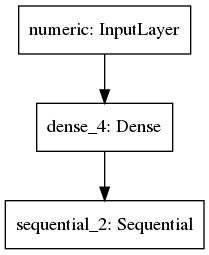

In [25]:
tf.keras.utils.plot_model(model)

In [26]:
def schedule(epoch, lr):
    print(epoch)
    if epoch == 0:
        return 0.1
    elif epoch == 1:
        return 0.01
    else:
        return 0.001
scheduler = tf.keras.callbacks.LearningRateScheduler(schedule, verbose=1)

history = model.fit(train_dataset, epochs=10, callbacks=[scheduler])

0

Epoch 00001: LearningRateScheduler reducing learning rate to 0.1.
Epoch 1/10
   6558/Unknown - 222s 34ms/step - loss: 0.1917 - accuracy: 0.9527 - auc: 0.5126

KeyboardInterrupt: 